In [1]:
import torch
import pandas
import numpy as np
import matplotlib.pyplot as plt
import visualization
from data import datasets, evaluation
import transformation

%load_ext autoreload
%autoreload 2 
%matplotlib agg

In [3]:
dataset = datasets.Izmailov(normalization="standardization")
dataset_train, dataset_validate = dataset.split(0.9)

#X_train, y_train = data_train_scaled[:, :-1], data_train_scaled[:, -1:]
#X_validate, y_validate = data_validate_scaled[:, :-1], data_validate_scaled[:, -1:]
#print(X_train.shape, X_validate.shape)

In [7]:
print(dataset, dataset_train, dataset_validate)
print(dataset[0], dataset_train[0], dataset_validate[0])
print(len(dataset), len(dataset_train), len(dataset_validate))

<data.datasets.izmailov.Izmailov object at 0x7fd911c63280> <data.datasets.izmailov.Izmailov object at 0x7fd911cedeb0> <data.datasets.izmailov.Izmailov object at 0x7fd911c63e50>
(tensor(0.1498), tensor(0.7132)) (tensor(0.9423), tensor(1.0002)) (tensor(-1.3895), tensor(-1.5360))
400 360 40


In [16]:
print(dataset[0:10][0].shape)

torch.Size([10])


In [ ]:
figure = visualization.TriangleFigure(width=np.sqrt(2) * dataset_train.data.shape[-1], height=np.sqrt(2) * dataset_train.data.shape[-1], prefix="x")
figure.plot(data=dataset_train.data)

In [4]:
def ridge(mean_pred, std_pred, y_true, parameters):
    factor = 0.5 / std_pred**2
    loss = factor * torch.pow(mean_pred - y_true, 2) + torch.log(std_pred)
    loss = loss.sum()
    loss = loss + parameters.T @ parameters
    return loss

def train(x, y, model, parameters, logstd, optimizer, loss_function, epochs, report_at, lr_0=None):
    # TODO: Add support for batches! Requires recalculation of deviding by n etc, or not?
    if lr_0 is None:
        for g in optimizer.param_groups:
            lr_0 = g["lr"]
    
    def lr_decay(lr, epoch):  # TODO: This cannot be the final version, since it is not general.
        return lr
        #return lr / (1.0 + 1.0e-5 * epoch)
    
    for epoch in range(epochs):
        # update learning rate
        lr_i = lr_decay(lr_0, epoch)
        for g in optimizer.param_groups:
            g["lr"] = lr_i
        
        optimizer.zero_grad()
        mean = model(x, parameters)
        loss = loss_function(mean, torch.exp(logstd), y, parameters)
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            if (epoch % report_at) == 0 or epoch == (epochs - 1):
                # training set
                with torch.no_grad():
                    y_pred = model(X_train, parameters)
                y_pred_rescaled = y_pred * dataset_validate.std[-1] + dataset_validate.mean[-1]
                y_train_rescaled = y_train * dataset_validate.std[-1] + dataset_validate.mean[-1]
                rmse_train = evaluation.rmse(y_pred_rescaled, y_train_rescaled)
                
                # validation set
                with torch.no_grad():
                    y_pred = model(X_validate, parameters)
                y_pred_rescaled = y_pred * dataset_validate.std[-1] + dataset_validate.mean[-1]
                y_validate_rescaled = y_validate * dataset_validate.std[-1] + dataset_validate.mean[-1]
                rmse_validate = evaluation.rmse(y_pred_rescaled, y_validate_rescaled)
                
                print("error at epoch {}".format(epoch), loss.item(), "lr", lr_i, "rmse train", rmse_train, "rmse validate", rmse_validate)
                pass

In [5]:
hidden_neurons = 16
model = transformation.Sequential([
    transformation.Linear(X_train.shape[-1], hidden_neurons),
    transformation.Activation(transformation.ActivationType.TANH),
    transformation.Linear(hidden_neurons, hidden_neurons),
    transformation.Activation(transformation.ActivationType.TANH),
    transformation.Linear(hidden_neurons, 1)
])

In [ ]:
thetas = []
for i in range(1):
    theta = (torch.randn(model.parameters_size) * 0.1).requires_grad_(True)
    logstd = (1.0 + torch.randn(1) * 0.1).requires_grad_(True)
    optimizer = torch.optim.Adam([theta, logstd])
    train(X_train, y_train, model, theta, logstd, optimizer, ridge, 100000, 1000)
    thetas.append(theta.clone().detach())
thetas = torch.stack(thetas, dim=0)

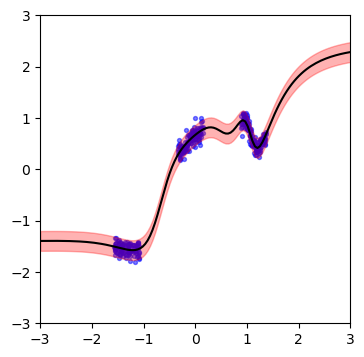

In [7]:
figure = visualization.RegressionFigure(width=4, height=4)
figure.plot(data_train_scaled, model, thetas, logstd)

In [8]:
#figure = visualization.TriangleFigure(width=12, height=12, prefix="x")
#figure.plot(data=theta_tensor)